In [1]:
import torch

#imports necessary to define a neural network 
import torch.nn as nn
import torch.nn.functional as F

#ensure you are using GPU.
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)

dtype = torch.cuda.FloatTensor
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

cuda:0


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(-0.5,0.5)])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/home/mohammad/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


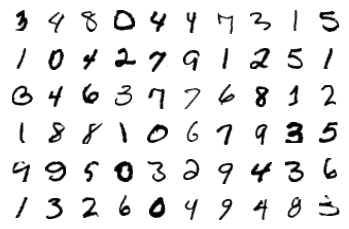

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net()
model.to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
logps = model(images.reshape([64,1,28,28]).cuda()) #log probabilities
loss = criterion(logps, labels.cuda()) #calculate the NLL loss

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.reshape([-1,1,28,28]).cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 0 - Training loss: 1.0052449099544778

Training Time (in minutes) = 0.10102138916651408
Epoch 1 - Training loss: 0.4474484550196733

Training Time (in minutes) = 0.19504021803538005
Epoch 2 - Training loss: 0.3481592562025798

Training Time (in minutes) = 0.28977129856745404
Epoch 3 - Training loss: 0.29864615440241565

Training Time (in minutes) = 0.3860650857289632
Epoch 4 - Training loss: 0.2701383659731287

Training Time (in minutes) = 0.4794443686803182
Epoch 5 - Training loss: 0.24483933965010302

Training Time (in minutes) = 0.5729457418123881
Epoch 6 - Training loss: 0.22934879421361729

Training Time (in minutes) = 0.6676475286483765
Epoch 7 - Training loss: 0.21886659275764214

Training Time (in minutes) = 0.7640054861704508
Epoch 8 - Training loss: 0.20085314579451008

Training Time (in minutes) = 0.862670894463857
Epoch 9 - Training loss: 0.19465480273617292

Training Time (in minutes) = 0.9576605359713236
Epoch 10 - Training loss: 0.18596859216126108

Training Time (

Predicted Digit = 0


<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


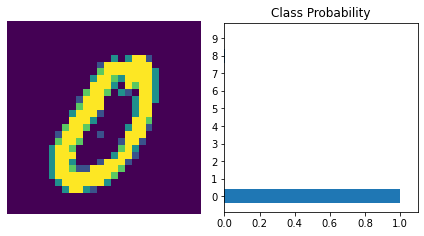

In [9]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
images, labels = next(iter(valloader))

img = images[0].reshape([-1,1,28,28])
with torch.no_grad():
    logps = model(img.cuda())

ps = torch.exp(logps)
probab = list(ps.detach().cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [10]:
torch.exp(model(img.cuda()))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[1.0000e+00, 1.1327e-22, 1.7513e-15, 8.6065e-23, 8.2895e-24, 4.2978e-16,
         6.2352e-12, 1.3068e-16, 1.1706e-16, 4.7142e-20]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [11]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].reshape([-1,1,28,28])
    with torch.no_grad():
        logps = model(img.cuda())

    
    ps = torch.exp(logps)
    probab = list(ps.detach().cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Number Of Images Tested = 10000

Model Accuracy = 0.9554


In [12]:
images.shape

torch.Size([16, 1, 28, 28])

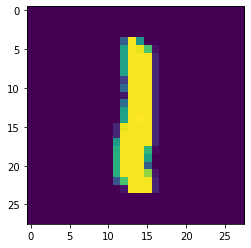

In [13]:
plt.imshow(img.detach().cpu().numpy().reshape(28,28))

In [14]:
def findloss(diff,pred):
    
#     diff is array of noise
#     pred is the prediction of the above trained model
    
    
    l1=(torch.square(diff))
    l1=torch.mean(l1)
    
    l2=pred**(-1)
    
    fl=l1**(4)+l2
    fl=fl**0.5
    
    return fl

In [15]:
diff=torch.rand(784).cuda().requires_grad_()

In [ ]:
learning_rate=0.001
num_descents=2000000 #number of times gradient descent is employed

img=img.reshape(784).cuda()
prevpred=0
for i in range(num_descents):
    
    imagef=img+diff
    pred=torch.exp(model(imagef.reshape([-1,1,28,28])))[0][8]
    totalloss=findloss(diff,pred)
    
    if pred>prevpred:
        #find gradients of totalt wrt yarray.
        totalloss.backward()

        gradients=diff.grad
        with torch.no_grad():
            diff[1:]=diff[1:]-learning_rate*gradients[1:]
        
        if i%10000 ==0:
            print('Loss and prediction by the model after '+str(i)+' steps of gradient descent are '+str(totalloss.item()),str(pred.item()))

        diff.grad.data.zero_()
    prevpred=pred

<ipython-input-6-121c0ab709c4>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Loss and prediction by the model after 0 steps of gradient descent are 170.46556091308594 3.4413340472383425e-05
Loss and prediction by the model after 10000 steps of gradient descent are 1.2781316041946411 0.6182990074157715
Loss and prediction by the model after 20000 steps of gradient descent are 1.0190986394882202 0.9786268472671509
Loss and prediction by the model after 40000 steps of gradient descent are 1.0089517831802368 0.9990507960319519
Loss and prediction by the model after 50000 steps of gradient descent are 1.0095722675323486 0.9978456497192383
Loss and prediction by the model after 90000 steps of gradient descent are 1.0085560083389282 0.999771237373352
Loss and prediction by the model after 100000 steps of gradient descent are 1.008419394493103 0.9999992847442627
Loss and prediction by the model after 120000 steps of gradient descent are 1.026283860206604 0.964810848236084
Loss and prediction by the model after 130000 steps of gradient descent are 1.0135688781738281 0.9

In [ ]:
plt.imshow(imagef.detach().cpu().numpy().reshape(28,28))

In [ ]:
plt.imshow(diff.detach().cpu().numpy().reshape(28,28))

In [ ]:
(img+diff).shape

In [ ]:
diff.is_leaf